In [140]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [173]:
import sys
sys.path.append('.')

import pandas as pd
import numpy as np
import incense
from incense import ExperimentLoader
import matplotlib.pyplot as plt
from src import settings

loader = ExperimentLoader(
    mongo_uri=None,    
    db_name='lions'
)

In [174]:
def find_similar(exp):
    """function to find based on hash.
    """
    hash_ = exp.to_dict()['config'][settings.EXP_HASH]
    return loader.find_by_config_key(settings.EXP_HASH, hash_)

def hash_based_bundle(exps):
    bundles = {}
    for exp in exps:
        hash_ = exp.to_dict()['config'][settings.MODEL_HASH]
        if hash_ in bundles:
            bundles[hash_].append(exp)
        else:
            bundles[hash_] = [exp]
    return bundles

def get_bo_plots(exp):
    return {k: v for k,v in exp.artifacts.items() if k.startswith('bo-plot')}

# Show aggregate


In [175]:
# From all to bundles.

exps = loader.find({})
hash_based_bundle(exps)

{'16d8211427d60b0d8d6bbfba3dd54e1b869241e3': [Experiment(id=1, name=test),
  Experiment(id=2, name=test),
  Experiment(id=3, name=test),
  Experiment(id=4, name=test),
  Experiment(id=5, name=test),
  Experiment(id=6, name=test),
  Experiment(id=7, name=test),
  Experiment(id=12, name=lions),
  Experiment(id=14, name=lions),
  Experiment(id=15, name=lions),
  Experiment(id=16, name=lions),
  Experiment(id=17, name=lions)],
 'e3b18f2abb39d37ae4fb16081c73ba2ea92495d9': [Experiment(id=8, name=test),
  Experiment(id=9, name=test),
  Experiment(id=10, name=test),
  Experiment(id=11, name=lions)],
 'a3d12273f59058dbd3fa777deea88b86d701ed98': [Experiment(id=13, name=lions)],
 'd2b84875557584f346950fa2f53fdb42f78aed88': [Experiment(id=18, name=lions),
  Experiment(id=26, name=lions),
  Experiment(id=27, name=lions),
  Experiment(id=30, name=lions),
  Experiment(id=33, name=lions),
  Experiment(id=35, name=lions),
  Experiment(id=39, name=lions),
  Experiment(id=53, name=lions)],
 '28016e64434f

In [176]:
# From one to all of same hash.

query = {"$and": [
            {"config.model.name": "GPModel"},
        ]}
exp = loader.find(query)[0]
exps = find_similar(exp)

In [177]:
# Calculate mean and variance of MSE
df_concat = pd.concat([exp.metrics['mse'] for exp in exps], axis=1)
mean = df_concat.mean(axis=1)
var = df_concat.var(axis=1)
plt.title('MSE')
plt.plot(df_concat.index, mean)
plt.fill_between(df_concat.index, mean - 2 * np.sqrt(var), mean + 2 * np.sqrt(var), alpha=0.2)

KeyError: 'mse'

In [185]:
sorted([('asd4.png', False), ('asd3.png',True)])

[('asd3.png', True), ('asd4.png', False)]

IndexError: list index out of range

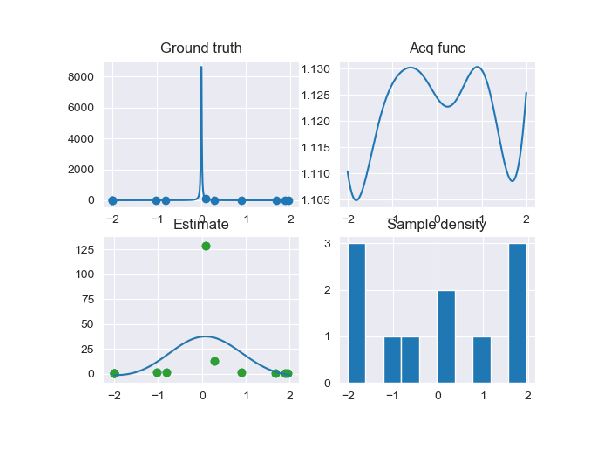

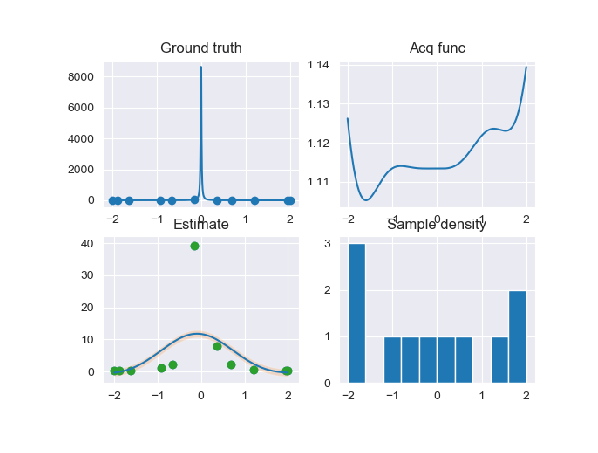

In [190]:
# Plot all last BO plot
# TODO: plot in grid
for exp in exps:
    name, last_plot = sorted(get_bo_plots(exp).items())[-1]
    last_plot.show()

# Single experiment explorer

In [191]:
# Find the latest (using internal api of loader...)
exp = loader._runs.find().sort([('timestamp', -1)]).limit(1)[0]
exp = loader._make_experiment(exp)

In [192]:
#exp = loader.find_by_id(-1)

def artifact_to_numpy(artifact):
    return np.load(artifact.file)

X = artifact_to_numpy(exp.artifacts['X.npy'])
Y = artifact_to_numpy(exp.artifacts['Y.npy'])

bo_plots_dict = get_bo_plots(exp)
bo_plots = [bo_plots_dict[k] for k in sorted(bo_plots_dict.keys())]

In [193]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact(i=(0, len(bo_plots)-1))
def show_bo_plot(i):
    bo_plots[i].show()

interactive(children=(IntSlider(value=0, description='i', max=1), Output()), _dom_classes=('widget-interact',)…

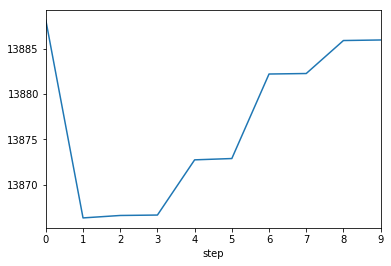

In [26]:
exp.metrics['mse'].plot()

# Dangour Zone! (Used to clean mongodb)

In [94]:
for exp in loader.find({}):
    exp.delete()

Are you sure you want to delete Experiment(id=1, name=test)? [y/N]y
Are you sure you want to delete Experiment(id=2, name=test)? [y/N]y
Are you sure you want to delete Experiment(id=3, name=test)? [y/N]y
